

```
Prevendo churn de clientes com machine learning
```



In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy


In [2]:

from google.colab import  files
arquivo = files.upload()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (1).csv


In [34]:
df =pd.read_csv('Telco-Customer-Churn.csv')

In [38]:
df_val = df.iloc[:10]

df_val


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [37]:
#Podemos retirar a coluna de id
df.drop('customerID', 1, inplace=True)

In [6]:
#verifica os tipos
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
#Parece que temos o campo Montlhy Charges como caracter, então teremos que ajustá-lo

df.TotalCharges = pd.to_numeric(df.TotalCharges)




ValueError: ignored

In [8]:
#é possivel usar 'coerce' mas o valores que tem espço em branco vão ficar vazio, podemos retirá-los
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [9]:
df.TotalCharges.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [10]:
#Vamos ver existem campos que estão com campos vazios
df[df.TotalCharges.isna()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [11]:
#Podemos excluir os que estão vazios
df.dropna(subset=['TotalCharges'], inplace=True)

In [12]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


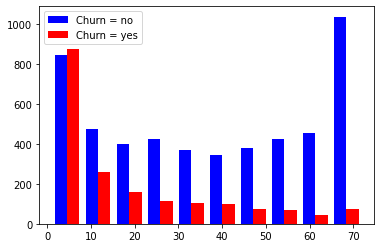

In [13]:
#Graficos para explorar os dados
#filtrar por churn no e yes e verificar os tenure
dfno = df[df.Churn=='No'].tenure
dfyes = df[df.Churn=='Yes'].tenure

plt.hist([dfno,dfyes], color=['blue', 'red'], label=['Churn = no', 'Churn = yes'])
plt.legend()

In [ ]:
#Graficos para explorar os dados
#filtrar por churn no e yes e verificar os Dependents
dfno = df[df.Churn=='No'].Dependents
dfyes = df[df.Churn=='Yes'].Dependents

plt.hist([dfno,dfyes], color=['blue', 'red'], label=['Churn = no', 'Churn = yes'])
plt.legend()

In [ ]:
#Graficos para explorar os dados
#filtrar por churn no e yes e verificar os MonthlyCharges
dfno = df[df.Churn=='No'].MonthlyCharges
dfyes = df[df.Churn=='Yes'].MonthlyCharges

plt.hist([dfno,dfyes], color=['blue', 'red'], label=['Churn = no', 'Churn = yes'])
plt.legend()

YES: 5163 No: 1869 % No: 26.58


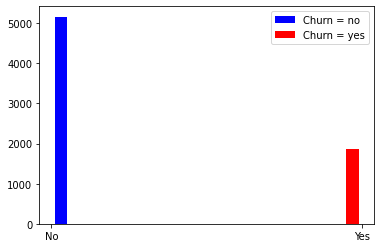

In [14]:
#Verificar quão balanceado esta o dataset
dfno = df[df.Churn=='No'].Churn
dfyes = df[df.Churn=='Yes'].Churn

total= dfno.count() + dfyes.count()
percent = round ((dfyes.count() / total) * 100 , 2)

print(f'YES: {dfno.count()}', f'No: {dfyes.count()}', f'% No: {percent}')

plt.hist([dfno,dfyes], color=['blue', 'red'], label=['Churn = no', 'Churn = yes'])
plt.legend()

In [15]:

#Ajustas os camp que tem "No service" para No
for i in df:  
  if df[i].dtypes=='object':
    print(f'{i} : {df[i].unique()}')


gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [16]:
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [17]:
#O que precisamos fazer agora e colocar os campos categoricos como numericos usando o hot enconding do panadas.
#Vamosa fazer essa tranformação pois pois é muito mais facil para os modelos trabalharam com valores, pois são modelos matematicos

dfnum= pd.get_dummies(data=df, columns=['gender','InternetService', 'Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'])
dfnum.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_

In [18]:
#Podemos ver um example dos valores codificados
dfnum.sample(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4531,0,9,79.35,661.25,Yes,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0
3592,0,1,45.65,45.65,Yes,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3846,0,8,45.45,411.75,No,1,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
5695,0,72,80.45,5737.60,No,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,0,0
5226,0,12,21.15,306.05,No,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0


In [19]:
#Label encoder coluna Churn
le = LabelEncoder()
dfnum['Churn'] = le.fit_transform(dfnum['Churn'])
dfnum.Churn.sample(15)

707     0
841     0
1647    1
2477    0
5620    0
3300    0
2867    0
50      0
2132    0
2073    0
2910    0
3609    0
2536    1
3414    0
3410    1
Name: Churn, dtype: int64

In [20]:
#Fazer o scale dos dados nas colunas de "tenure", monthly charges e total cherges'

scaler = MinMaxScaler()
dfnum[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(dfnum[['tenure','MonthlyCharges','TotalCharges']])
dfnum.sample(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5406,0,0.985915,0.785572,0.795234,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
5537,1,0.985915,0.963184,0.922894,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0
3917,1,0.000000,0.505970,0.005804,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
4169,0,0.197183,0.825871,0.165988,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0
4300,0,0.323944,0.063184,0.067673,0,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0


In [21]:
#Separar os dados em features e labels
features = dfnum.drop('Churn', 1)
label = dfnum['Churn']
print(label)


0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64


In [22]:
#Pegar uam parte para validação
val = features.head(10)
val

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.000000,0.115423,0.001275,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
1,0,0.464789,0.385075,0.215867,0,1,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1
2,0,0.014085,0.354229,0.010310,0,1,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1
3,0,0.619718,0.239303,0.210241,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0
4,0,0.014085,0.521891,0.015330,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
5,0,0.098592,0.809950,0.092511,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0
6,0,0.295775,0.704975,0.222779,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,0
7,0,0.126761,0.114428,0.032668,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1
8,0,0.380282,0.861194,0.349325,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0
9,0,0.859155,0.377114,0.400317,0,1,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0


In [23]:
#Novo featured
features = features.iloc[10:]
features

label = label.iloc[10:]
label


10      0
11      0
12      0
13      1
14      0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7022, dtype: int64

In [24]:
#Separa train test e split
X_Train, X_test, y_train, y_test = train_test_split(features,label,test_size=0.2, random_state=42)
print(X_Train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(5617, 41) (5617,)
(1405, 41) (1405,)


In [25]:
#impotar tensor flow e keras

model = Sequential([
  Dense(20, input_shape=(41,), activation='relu'),
  Dense(52, activation='relu'),
  Dense(1,activation='sigmoid')
])

#Passando parametro de execução
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  

#Um detalhe importante a ser mencionado,e que estamos passando as camadas da rede neural, e na o primieiro comando na verdade já é a segunda camada
# e neste caso estamos passando 20 neuronio(valor arbitrário) e o segundo parêmtro é a uqbntidade de entradas, que no nosso caso são 26 campos e a função
#de ativação usada no neurônio que neste caso é a relu.

#ReLU é a função de ativação mais amplamente utilizada ao projetar redes neurais atualmente.
#Primeiramente, a função ReLU é não linear, o que significa que podemos facilmente copiar os erros para trás e ter várias camadas de 
#neurônios ativados pela função ReLU.

#A principal vantagem de usar a função ReLU sobre outras funções de ativação é que ela não ativa todos os neurônios ao mesmo tempo. 

In [26]:
#Podemos ver como foi criado nosso modelo
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 52)                1092      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 53        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_Train,y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.7198
Epoch 2/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7794
Epoch 3/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7960
Epoch 4/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4254 - accuracy: 0.8011
Epoch 5/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4205 - accuracy: 0.7979
Epoch 6/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4168 - accuracy: 0.8035
Epoch 7/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4136 - accuracy: 0.8079
Epoch 8/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4110 - accuracy: 0.8088
Epoch 9/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4098 - accuracy: 0.8075
Epoch 10/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4062 - accura

In [28]:
model.evaluate(X_test,y_test)

44/44 [==============================] - 0s 879us/step - loss: 0.5119 - accuracy: 0.7644


[0.5118694305419922, 0.7644128203392029]

In [44]:
pred_val = model.predict(val)
print(pred_val)

[[0.4737529 ]
 [0.00474805]
 [0.162788  ]
 [0.01245227]
 [0.69833994]
 [0.9276463 ]
 [0.28171492]
 [0.06411505]
 [0.7781007 ]
 [0.01028946]]


In [69]:
y_pred = []
for i in pred_val:
  if i > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

cliente = df_val['customerID']
real = df_val['Churn']
pred = list(pred_val.flatten())

df=pd.DataFrame({'cliente':cliente, 'previsao':pred, 'real':real, 'churn':y_pred})

print(df)

      cliente  previsao real  churn
0  7590-VHVEG  0.473753   No      0
1  5575-GNVDE  0.004748   No      0
2  3668-QPYBK  0.162788  Yes      0
3  7795-CFOCW  0.012452   No      0
4  9237-HQITU  0.698340  Yes      1
5  9305-CDSKC  0.927646  Yes      1
6  1452-KIOVK  0.281715   No      0
7  6713-OKOMC  0.064115   No      0
8  7892-POOKP  0.778101  Yes      1
9  6388-TABGU  0.010289   No      0


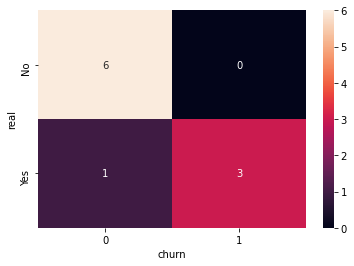

In [70]:


import seaborn as sns

df = pd.DataFrame(df, columns=['real','churn'])
confusion_matrix = pd.crosstab(df['real'], df['churn'], rownames=['real'], colnames=['churn'])

sns.heatmap(confusion_matrix, annot=True)


